In [1]:
import numpy as np
import os
from scipy.linalg import schur
import tensorflow as tf
from backend.attention_network import Model
import backend as be
from backend.simulation_tools import Simulator
from backend.weight_initializer import weight_initializer
from tasks import color_matching as cm
import matplotlib.pyplot as plt
import time
import pickle
%matplotlib inline

In [2]:
def softmax(data):
    return np.exp(data).T/np.sum(np.exp(data),axis=1)

def relu(x):
    return np.maximum(x,0)

def state_to_output(s,w):
    o = np.zeros([s.shape[0],s.shape[1],w['b_out'].shape[0]])
    for ii in range(s.shape[1]):
        o[:,ii,:] = relu(s[:,ii,:]).dot(w['W_out'].T) + w['b_out']
    return o

def get_rts(out,thresh=.4):

    n_trials = out.shape[1]
    n_steps = out.shape[0]

    rts = -np.ones(n_trials).astype(int)  
    choice = np.zeros(n_trials)
    for ii in range(n_trials): 
        cross = np.where(np.abs(out[:,ii,0]-out[:,ii,1])>thresh)
        if len(cross[0]) != 0:
            rts[ii] = np.min(cross[0])
            choice[ii] = np.argmax(out[rts[ii],ii,:])
            
    return rts,choice

def ols(X,Y,reg=0.):
    
    X = np.hstack([X,np.ones([X.shape[0],1])])
    w = np.linalg.inv(X.T.dot(X) + reg*np.eye(X.shape[1])).dot(X.T).dot(Y)
    
    return w,X.dot(w)

def run_ols(X,w):
    
    X = np.hstack([X,np.ones([X.shape[0],1])])
    
    return X.dot(w)

In [3]:

n_hidden  = 250
tau = 100.0 #As double
dt = 20.0  #As double
dale_ratio = None
rec_noise = 0.1
stim_noise = 0.1
batch_size = 64

cohs = [.1,.2,.5,.7,1.]
rt_version = False
reward_version = False

#train params
learning_rate = .0001
training_iters = 200000
display_step = 20

'''curriculum trained: 
    cm_att_curr1 - with attention (400 ms stimuli epoch)
    cm_att_rew_curr0 - with attention and rewards (400 ms stimuli epoch)
    cm_att_curr2 - with attention (stimulus stays until end of trial)
    cm_att_l2_curr0 - same as cm_att_curr2 with l2 penalty on attention
'''

tag = 'cm_att_l2_curr0'
weights_path = '../weights/'+tag+'.npz'
params_path = '../weights/'+tag+'_params.p'

params = cm.set_params(coherences=cohs, 
                    stim_noise = stim_noise, rec_noise = rec_noise, L1_rec = 0, 
                    L2_firing_rate = .2, sample_size = 128, epochs = 100, N_rec = n_hidden, 
                    dale_ratio=dale_ratio, tau=tau, dt = dt, task='n_back',rt_version=rt_version,reward_version=reward_version)

generator = cm.generate_train_trials(params)

In [4]:
#Attention Weight specific params
params['L2_attention'] = .002  #attention regularizer
params['tau_fw'] = 50.       #initial time constant of attention update
params['gamma_train'] = True  #trainable gamma (dt/tu_fw)
params['phi_train'] = False    #trainable phi (sensitivity to fws)
params['global_phi'] = False  #Single global or synapse specific plasticity

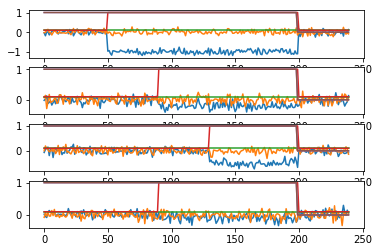

In [5]:
trial = cm.build_train_trials(params)

for ii in range(4):
    plt.subplot(4,1,ii+1)
    plt.plot(trial[0][ii,:,:])
    plt.plot(trial[1][ii,:,:])
    plt.plot(trial[2][ii,:,:])
plt.show()

In [6]:
trial[2].shape

(128, 240, 2)

In [7]:
# output_weights_path = weights_path
# params['init_type'] = 'gaussian'
# 'external weight intializer class'
# autapses = True
# w_initializer = weight_initializer(params,output_weights_path[:-4] + '_init',autapses=autapses)
# input_weights_path = w_initializer.gen_weight_dict()
# params['load_weights_path'] = input_weights_path + '.npz'


# w_init = np.load(input_weights_path + '.npz')

# plt.imshow(w_init['W_rec'],interpolation='none')

# plt.figure()
# plt.plot(w_init['W_in'])
# plt.show()


In [8]:
#regular training
if False:

    tf.reset_default_graph()
    model = Model(params)
    sess = tf.Session()
    t,att,phi,gamma,s,trial_data = model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
                save_weights_path = weights_path, display_step=display_step,batch_size=batch_size)

    sess.close()

In [9]:
#curriculum learning
if False:

    coh_factors = np.array([1.,.8,.5,.3,.1]) #np.arange(1.,0,-.2)

    params['load_weights_path'] = None
    params['N_batch'] = params['sample_size'] = 128
    training_iters = 300000


    #train loop
    for coh_factor in coh_factors:
        print coh_factor
        tf.reset_default_graph()
        params['coherences'] = coh_factor*np.array(cohs)
        if coh_factor == coh_factors[-1]:
            training_iters = 300000

        generator = cm.generate_train_trials(params)
        model = Model(params)

        sess = tf.Session()
        t,att,phi,gamma,s,trial_data = model.train(sess, generator, learning_rate = learning_rate, training_iters = training_iters,
                    save_weights_path = weights_path, display_step=display_step,batch_size=batch_size)

        sess.close()

        params['load_weights_path'] = weights_path
        training_iters = 100000


    #save train params
    pickle.dump( params, open( params_path, "wb" ) )

In [43]:
#run null trials

tf.reset_default_graph()
params['coherences'] = np.array([0.])
params['N_batch'] = params['sample_size'] = 10000
params['load_weights_path'] = weights_path

generator = cm.generate_train_trials(params)
model = Model(params)

null_trials = generator.next()

sess = tf.Session()

sess.run(tf.global_variables_initializer())
att_null,s_null = sess.run([model.attention,model.states], feed_dict={model.x: null_trials[0]})

sess.close()



Loading Weights


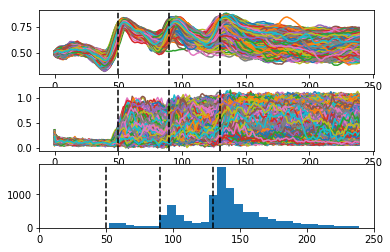

In [44]:
w = np.load(weights_path)

att_null = np.asarray(att_null)
s_null = np.asarray(s_null)
o_null = state_to_output(s_null,w)

soft_att_null = np.zeros(att_null.shape)
for ii in range(soft_att_null.shape[1]):
    soft_att_null[:,ii,:] = softmax(att_null[:,ii,:]).T

rts,choice = get_rts(o_null,thresh=.6)

plt.subplot(3,1,1)
plt.plot(soft_att_null[:,:,0])
plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')

plt.subplot(3,1,2)
plt.plot(o_null[:,:,0])
plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')

plt.subplot(3,1,3)
plt.hist(rts[rts>0],30)
plt.xlim([0,250])
plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')


plt.show()

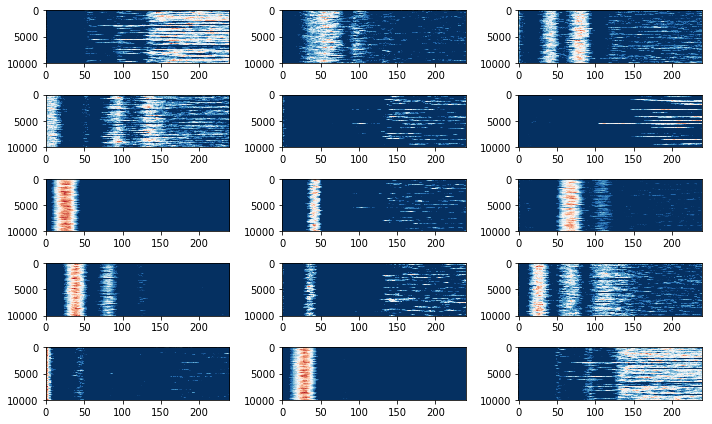

In [45]:
# plt.hist(rts[np.logical_and(rts>0,rts<130)],30)

plt.figure(figsize=(10,6))
for ii in range(15):
    plt.subplot(5,3,ii+1)
    plt.imshow(relu(s_null[:,:,20+ii]).T,aspect='auto',interpolation='none',cmap='RdBu_r')
# plt.axvline(50,c='r',linestyle='--')
# plt.axvline(90,c='r',linestyle='--')
# plt.axvline(130,c='r',linestyle='--')
plt.tight_layout()
plt.show()

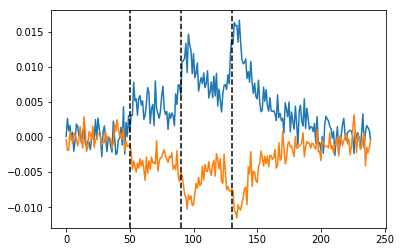

In [49]:
#psychophysical kernel
plt.plot(np.mean(null_trials[0][choice==0],axis=0)[:,0])
plt.plot(np.mean(null_trials[0][choice==1],axis=0)[:,0])

plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')

plt.show()

In [54]:
M = np.zeros([10000,4])
M[:,0] = rts
M[:,1] = 0. #correct.astype('int')
M[:,2] = 0
M[:,3] = 1.

np.save('rnn_null_data',M)

In [13]:
#run regular trials

tf.reset_default_graph()
params['coherences'] = np.array([.005,.01,.02,.03,.05,.08,.1])
params['N_batch'] = params['sample_size'] = 1000
params['load_weights_path'] = weights_path

generator = cm.generate_train_trials(params)
model = Model(params)

reg_trials = generator.next()

sess = tf.Session()

sess.run(tf.global_variables_initializer())
att,s = sess.run([model.attention,model.states], feed_dict={model.x: reg_trials[0]})

sess.close()

Loading Weights


Accuracy: 0.898


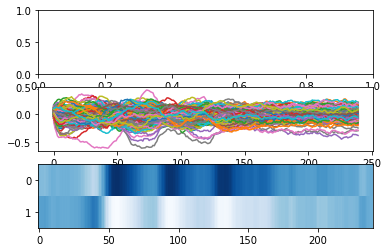

In [15]:

# t,att,phi,gamma,s,trial_data = t

w = np.load(weights_path)

# print np.asarray(att).shape
# print t
# print s[0].shape
# print trial_data[0].shape

att_ = np.asarray(att)
s_ = np.asarray(s)
o_ = state_to_output(s_,w)

rts,choice = get_rts(o_,thresh=.8)

# rule = np.argmax(trial_data[0][:,50,:2],axis=1)
target = np.argmax(reg_trials[1][:,199,:],axis=1)
# choice = np.argmax(o_[-1,:,:],axis=1)
correct = choice == target

# coh = np.zeros(len(rule))
# for ii in range(len(rule)):
#     coh[ii] = np.mean(trial_data[0][ii,100:180,rule[ii]+2],axis=0)

print('Accuracy: {}'.format(np.mean(correct)))


trial = 1
plt.subplot(3,1,1)
# plt.plot(trial_data[0][trial,:,:])
plt.subplot(3,1,2)
plt.plot(s_[:,trial,:])
plt.subplot(3,1,3)
plt.imshow(softmax(att_[:,trial,:]),aspect='auto',interpolation='none',cmap='Blues')
# plt.imshow((np.exp(att_[:,trial,:]).T/np.sum(np.exp(att_[:,trial,:]),axis=1)),aspect='auto',interpolation='none',cmap='Blues')
# plt.colorbar()
plt.legend(range(4),frameon=False,fontsize=8)
plt.show()

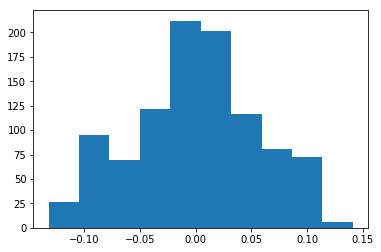

In [22]:
def get_timing(trials):
    times = np.zeros(trials[1].shape[0])
    times[np.sum(trials[1][:,131,:],axis=1)>.3] = 130.
    times[np.sum(trials[1][:,91,:],axis=1)>.3] = 90.
    times[np.sum(trials[1][:,51,:],axis=1)>.3] = 50.
    
    
    
    return times

times = get_timing(reg_trials).astype('int')

coh = np.zeros(len(times))
for ii in range(len(times)):
    coh[ii] = np.mean(reg_trials[0][ii,times[ii]:times[ii]+40,0])

plt.hist(coh)
plt.show()

In [26]:
M = np.zeros([1000,4])
M[:,0] = rts
M[:,1] = correct.astype('int')
M[:,2] = coh
M[:,3] = 1.

np.save('rnn_rdm_data',M)

# from ddm import Sample

# conditions = ["coh", "monkey", "trgchoice"]
# rnn_sample = Sample.from_numpy_array(M, conditions)
# # correct.astype('int')

In [24]:
# colors = ['b','g','r','c']

# soft_att_0 = softmax(np.mean(att_[:,rule==0,:],axis=1)).T
# soft_att_1 = softmax(np.mean(att_[:,rule==1,:],axis=1)).T

# for ii in range(4):
#     plt.plot(soft_att_0[:,ii],colors[ii])
#     plt.plot(soft_att_1[:,ii],colors[ii],linestyle='--',label='_nolegend_')
    
# plt.legend(['rule0','rule1','in0','in1'],frameon=False)
# plt.show()

(240, 327)


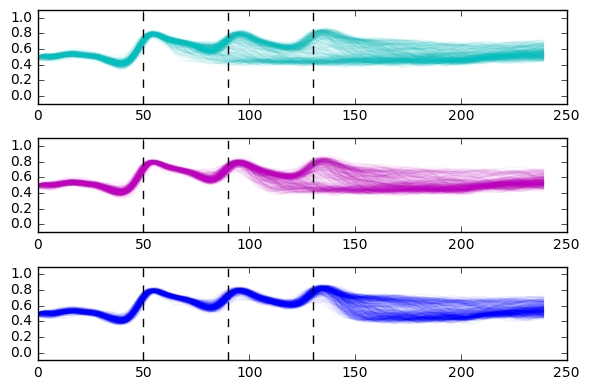

In [45]:
soft_att = np.zeros(att_.shape)
for ii in range(soft_att.shape[1]):
    soft_att[:,ii,:] = softmax(att_[:,ii,:]).T
    
    
# plt.plot(soft_att[:,:,0])
# plt.show()

print soft_att[:,times==50,0].shape

plt.subplot(3,1,1)
plt.plot(soft_att[:,times==50,0],'c',alpha=.05)
plt.ylim([-.1,1.1])
plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')

plt.subplot(3,1,2)
plt.plot(soft_att[:,times==90,0],'m',alpha=.05)
plt.ylim([-.1,1.1])
plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')

plt.subplot(3,1,3)
plt.plot(soft_att[:,times==130,0],'b',alpha=.05)
plt.ylim([-.1,1.1])
plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')

plt.tight_layout()
plt.show()

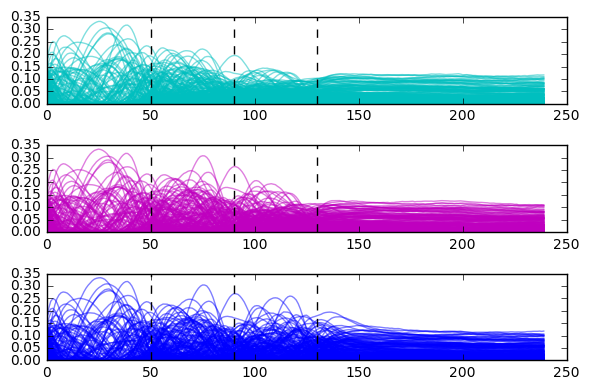

In [42]:
plt.subplot(3,1,1)
plt.plot(np.mean(relu(s_[:,times==50,:]),axis=1),'c',alpha=.5)

# plt.plot(np.mean(np.mean(relu(s_[:,times==90,:]),axis=1),axis=1),'m',alpha=1.)
# plt.plot(np.mean(np.mean(relu(s_[:,times==130,:]),axis=1),axis=1),'b',alpha=1.)

# plt.ylim([-.1,1.1])
plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')

plt.subplot(3,1,2)
plt.plot(np.mean(relu(s_[:,times==90,:]),axis=1),'m',alpha=.5)
# plt.ylim([-.1,1.1])
plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')

plt.subplot(3,1,3)
plt.plot(np.mean(relu(s_[:,times==130,:]),axis=1),'b',alpha=.5)
# plt.ylim([-.1,1.1])
plt.axvline(50,c='k',linestyle='--')
plt.axvline(90,c='k',linestyle='--')
plt.axvline(130,c='k',linestyle='--')

plt.tight_layout()
plt.show()

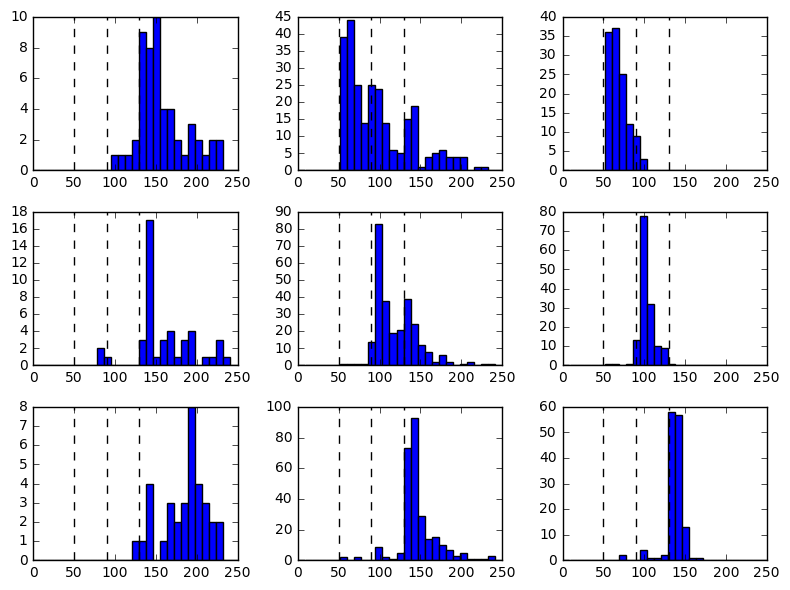

In [30]:
time_idx = [50,90,130]
coh_bins = [[0,.01],[.01,.5],[.05,1.]]

plt.figure(figsize=(8,6))
count=1
for ii in range(len(time_idx)):
    for jj in range(len(coh_bins)):
        plt.subplot(3,3,count)
        coh_idx = np.logical_and(np.abs(coh)>coh_bins[jj][0],np.abs(coh)<coh_bins[jj][1])
        plt.hist(rts[np.logical_and(times==time_idx[ii],coh_idx)],bins=np.linspace(0,250,30))
        plt.xlim([0,250])
        
        plt.axvline(50,c='k',linestyle='--')
        plt.axvline(90,c='k',linestyle='--')
        plt.axvline(130,c='k',linestyle='--')
        
        count+=1
    
plt.tight_layout()
plt.show()

In [27]:
for jj in range(len(coh_bins)):
    coh_idx = np.logical_and(np.abs(coh)>coh_bins[jj][0],np.abs(coh)<coh_bins[jj][1])
    print np.mean(correct[coh_idx])

0.71875
0.940476190476
0.982843137255
